# Regulome Explorer - Gene Expression

Computing associations of between Gene expression of a list of genes and other molecular features available in TCGA


### Authentication
Authorize our access to BigQuery and the Google Cloud. For more information see ['Quick Start Guide to ISB-CGC'](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/HowToGetStartedonISB-CGC.html) and alternative authentication methods can be found [here ](https://googleapis.github.io/google-cloud-python/latest/core/auth.html).

### Import Python libraries

In [167]:
#%load_ext autoreload
#%autoreload 2
from google.cloud import bigquery
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import ipywidgets as widgets
import re_module.bq_functions as regulome

### Specify Parameters
The parameters for this experiment are the cancer type (study) and a list of genes. The list of genes is used to generate a table with gene expression data for these genes, however the user can generate the data acoording to some criteria, for example we could have generated a table with the most variables gene, please refer to other notebooks for ways to generate a table of genes.

In [159]:
[study, feature2_name, gene_names] = regulome.makeWidgets()

### Build Bigquery string
The Bigquery to compute associations is composed of the following four tables: 
  - The first table contains Gene Expression data from
  - The second table contains data of the molecular feature 2. 
  - The third table is a combination of tables 1 and 2 
  - The fourth table is contains the statistics

In [160]:
query_table1= """
table1 AS (
SELECT  symbol, data, SampleBarcode,
        DENSE_RANK() OVER (PARTITION BY symbol ORDER BY data ASC) AS rnkdata 
FROM ( 
   SELECT 
         Symbol AS symbol, AVG( LOG10( normalized_count + 1 )) AS data, SampleBarcode,
         COUNT( SampleBarcode)  as nsample 
   FROM  `pancancer-atlas.Filtered.EBpp_AdjustPANCAN_IlluminaHiSeq_RNASeqV2_genExp_filtered` 
   WHERE Study = '{0}' AND Symbol in UNNEST(@PARAMETERLIST)
   GROUP BY 
         SampleBarcode, symbol
)
WHERE nsample = 1
)
""".format( study.value )

The following tables are specific to the selected molecular feature.  The final query (sql) can printed and run directly on Bigquery console. 

In [161]:
query_table2 = regulome.get_feature2_table( study.value, feature2_name.value )
str_summarized = regulome.get_summarized_table( feature2_name.value )
str_stats = regulome.get_stat_table( feature2_name.value )

sql = ( 'WITH' + query_table1 + ',' + query_table2 + ',' + str_summarized + str_stats) 

### Run the Bigquery

In [162]:
bqclient = bigquery.Client()
gene_list = [ x.strip() for x in gene_names.value.split(',') ]
df_results = regulome.runQuery ( bqclient, sql, gene_list , dryRun=False )


 in runQuery ... 
    this query processed 8633483721 bytes 


In [163]:
df_results[0:10]

,symbol1,symbol2,rho
0,IGF2,IGF2AS,0.760481
1,IGF2,INS-IGF2,0.666674
2,IGF2,LRRC4B,0.637915
3,IGF2,ZBTB46,0.612028
4,IGF2,ADAM33,0.602187
5,IGF2,NRXN2,0.601245
6,IGF2,F10,0.599612
7,IGF2,CPXM1,0.591952
8,IGF2,MAGEL2,0.580652
9,IGF2,PSD,0.574342


## Analyze a pair of features
From the table above please select a pair of features names to perform a statitical analysis and display the data


In [154]:
[name1 , name2 ] = regulome.makeWidgetsPair()

In [164]:
pair_query = regulome.get_query_pair(name1.value,name2.value,study.value,'Gene Expression',feature2_name.value)

In [165]:
df_pair = regulome.runQuery( bqclient, pair_query, [] , dryRun=False )


 in runQuery ... 
    the results for this query were previously cached 


SpearmanrResult(correlation=0.5993988063342942, pvalue=3.302482942871283e-56)


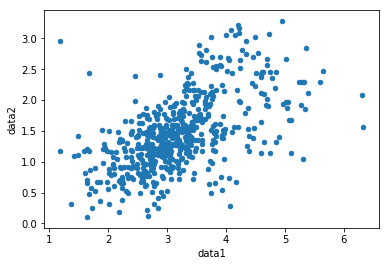

In [166]:
regulome.plot_statistics_pair ( df_pair, feature2_name.value )  